In [1]:
import pdb

In [2]:
# pdb.set_trace()

In [3]:
import torch

In [4]:
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5).softmax(dim=1)

In [5]:
target

tensor([[0.0939, 0.0956, 0.2387, 0.3214, 0.2504],
        [0.5152, 0.0805, 0.1735, 0.0819, 0.1489],
        [0.0680, 0.0394, 0.0111, 0.2271, 0.6543]])

In [6]:
input

tensor([[-1.4974,  0.6848,  0.0614, -1.3641, -0.1052],
        [ 0.8279, -0.2838, -0.3835, -1.0058, -0.7883],
        [-1.0865,  0.1394, -0.4530,  1.0402, -1.2003]], requires_grad=True)

In [7]:
import torch.nn as nn

In [8]:
loss = nn.CrossEntropyLoss()

In [9]:
loss??

In [10]:
import torch.nn.functional as F

In [11]:
F.cross_entropy??

### Start actual lesson

In [12]:
import pickle, gzip, math, os, time, shutil,torch,matplotlib as mpl, numpy as np
from pathlib import Path
from torch import tensor
from fastcore.test import test_close
torch.manual_seed(42);

In [13]:
import matplotlib.pyplot as plt
# TODO: experiment with different values here once we have images
mpl.rcParams['image.cmap'] = 'gray'

/var/folders/c8/mt_y_mg14_s14_slht8ds95w0000gn/T/ipykernel_22438/2324971393.py:1: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  plt.plot(torch.range(0, 10), torch.range(0, 10));


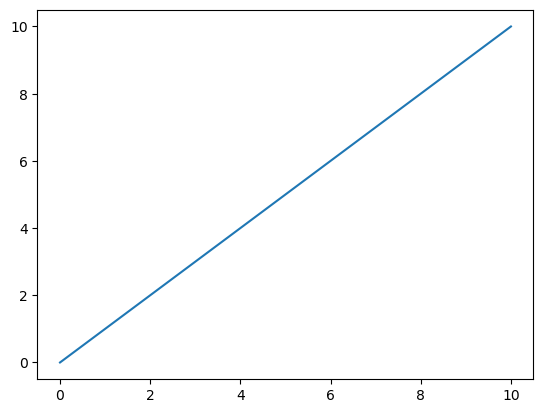

In [14]:
plt.plot(torch.range(0, 10), torch.range(0, 10));

In [15]:
torch.set_printoptions(precision=2, linewidth=125, sci_mode=False)
np.set_printoptions(precision=2, linewidth=125)

In [118]:
path_data = Path('data')
path_gz = path_data/'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

# import pdb; pdb.set_trace()
type(x_train), x_train.shape

(numpy.ndarray, (50000, 784))

In [119]:
x_train, y_train, x_valid, y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))

In [120]:
type(x_train), x_train.shape

(torch.Tensor, torch.Size([50000, 784]))

In [121]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#### Foundations version

In [133]:
n,m = x_train.shape
c = y_train.max() + 1
n,m,c

(50000, 784, tensor(10))

In [134]:
nh = 50

In [135]:
w1 = torch.randn(m, nh)
b1 = torch.zeros(nh)
w2 = torch.randn(nh, 1)
b2 = torch.zeros(1)

In [136]:
def lin(x, w, b): return x@w+b

In [137]:
x_valid.shape

torch.Size([10000, 784])

In [138]:
t = lin(x_valid, w1, b1)

x_valid.shape, w1.shape, b1.shape, t.shape

(torch.Size([10000, 784]),
 torch.Size([784, 50]),
 torch.Size([50]),
 torch.Size([10000, 50]))

In [139]:
def relu(x):
    return x.clamp_min(0.)

In [140]:
t

tensor([[ -9.43,   1.46,  11.77,  ...,  -4.05,  11.49,  10.52],
        [-17.37,   0.57,  17.38,  ...,   6.78,  10.87,  -5.41],
        [ -2.73,   2.84,   2.44,  ...,   6.01,  -2.25,  13.03],
        ...,
        [ -4.24, -11.04,  14.21,  ...,   5.52,  -4.46,  -5.33],
        [ -6.48,   5.49,   7.10,  ...,  -3.05,  -1.82,  10.65],
        [ -6.43, -14.77,   0.20,  ...,   2.83,  -4.23,   4.71]])

In [141]:
t = relu(t)
t

tensor([[ 0.00,  1.46, 11.77,  ...,  0.00, 11.49, 10.52],
        [ 0.00,  0.57, 17.38,  ...,  6.78, 10.87,  0.00],
        [ 0.00,  2.84,  2.44,  ...,  6.01,  0.00, 13.03],
        ...,
        [ 0.00,  0.00, 14.21,  ...,  5.52,  0.00,  0.00],
        [ 0.00,  5.49,  7.10,  ...,  0.00,  0.00, 10.65],
        [ 0.00,  0.00,  0.20,  ...,  2.83,  0.00,  4.71]])

In [142]:
def model(xb):
    l1 = lin(xb, w1, b1)
    l2 = relu(l1)
    return lin(l2, w2, b2)

In [143]:
res = model(x_valid)
res.shape

torch.Size([10000, 1])

In [144]:
res.shape, y_valid.shape

(torch.Size([10000, 1]), torch.Size([10000]))

In [145]:
(res - y_valid).shape # best understanding of broadcasting rules

torch.Size([10000, 10000])

In [146]:
res.squeeze().shape

torch.Size([10000])

In [147]:
res[None, :].squeeze().shape

torch.Size([10000])

### Get rid of the trailing 1 to get MSE

In [148]:
res[:,0].shape

torch.Size([10000])

In [149]:
y_train, y_valid = y_train.float(), y_valid.float()

preds = model(x_train)
preds.shape

torch.Size([50000, 1])

In [220]:
def mse(output, targ):
    return (output[:,0] - targ).pow(2).mean()
    # return (targ - output[:,0]).pow(2).mean()

In [151]:
res[:,0].shape

torch.Size([10000])

In [152]:
res[:,0].mean()

tensor(0.43)

In [153]:
mse(preds, y_train)

tensor(688.92)

### Gradients and backward pass

In [154]:
from sympy import symbols,diff
x,y = symbols('x y')
diff(x**2, x)

2*x

In [155]:
symbols??

In [156]:
diff(3*x**2+9, x)

6*x

In [157]:
x_valid.shape

torch.Size([10000, 784])

In [158]:
inp = x_valid[:4,:]
w = torch.randn(784, 10)
b = torch.zeros(10)

In [159]:
out = inp@w + b
out.shape

torch.Size([4, 10])

In [160]:
inp.shape, out.shape

(torch.Size([4, 784]), torch.Size([4, 10]))

In [161]:
inp.unsqueeze(-1).shape, out.unsqueeze(1).shape

(torch.Size([4, 784, 1]), torch.Size([4, 1, 10]))

In [49]:
x_valid.sum(0).shape

torch.Size([784])

In [50]:
torch.sum??

In [51]:
from fastcore.test import test_close

In [52]:
a = (inp.unsqueeze(-1) * out.unsqueeze(1)).sum(0)

In [53]:
b = inp.t() @ out

In [54]:
a.shape, b.shape

(torch.Size([784, 10]), torch.Size([784, 10]))

In [55]:
test_close(a, b)

In [221]:
def lin_grad(inp, out, w, b):
    inp.g = out.g @ w.t()
    w.g = inp.t() @ out.g
    b.g = out.g.sum(0)

In [222]:
def forward_and_backward(inp, targ):
    # forward pass
    l1 = lin(inp, w1, b1)
    l2 = relu(l1)
    out = lin(l2, w2, b2)
    diff = out[:,0] - targ
    loss = diff.pow(2).mean()
    
    # backward pass
    out.g = 2.*diff[:,None] / inp.shape[0] # try negative here
    lin_grad(l2, out, w2, b2)
    l1.g = (l1 > 0).float() * l2.g
    lin_grad(inp, l1, w1, b1)

In [223]:
forward_and_backward(x_train, y_train)

In [224]:
# save grads
def get_grad(x): return x.g.clone()

In [225]:
chks = w1,w2,b1,b2,x_train

In [226]:
grads = w1g,w2g,b1g,b2g,x_train_g = tuple(map(get_grad, chks))

In [227]:
def mkgrad(x):
    return x.clone().requires_grad_(True)

In [228]:
ptgrads = w1pt,w2pt,b1pt,b2pt,x_train_pt = tuple(map(mkgrad, chks))

In [229]:
def forward(inp, targ):
    # forward pass
    l1 = lin(inp, w1pt, b1pt)
    l2 = relu(l1)
    out = lin(l2, w2pt, b2pt)
    return mse(out, targ)

In [230]:
loss = forward(x_train_pt, y_train)

In [231]:
loss.backward()

In [232]:
ptgrads[0].grad

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [233]:
len(grads), len(ptgrads)

(5, 5)

In [234]:
for a, b in zip(grads, ptgrads):
    # print(a)
    # print(b.grad)
    test_close(a, b.grad, eps=0.1)

In [235]:
test_close??

## Refactor model

In [264]:
def f(a, b, *c):
    print(a, b, *c, c)

In [265]:
f(1, 2, 3, 4, 5)

1 2 3 4 5 (3, 4, 5)


In [240]:
class Relu():
    def __call__(self, inp):
        self.inp = inp
        self.out = inp.clamp_min_(0)
        return self.out
    
    def backward(self):
        self.inp.g = (self.inp > 0).float() * self.out.g

In [241]:
class Lin():
    def __init__(self, w, b):
        self.w, self.b = w,b
    
    def __call__(self, inp):
        self.inp = inp
        self.out = inp @ self.w + self.b
        return self.out
    
    def backward(self):
        self.inp.g = self.out.g @ self.w.t()
        self.w.g = self.inp.t() @ self.out.g
        self.b.g = self.out.g.sum(0)

In [242]:
class Mse():
    def __call__(self, inp, target):
        self.inp,self.target = inp,target
        self.out = mse(inp, target)
        return self.out
    
    def backward(self):
        self.inp.g = 2. * (self.inp.squeeze() - self.target).unsqueeze(-1) / self.target.shape[0]

In [243]:
class Model():
    def __init__(self, w1, b1, w2, b2):
        self.layers = [Lin(w1,b1), Relu(), Lin(w2,b2)]
        self.loss = Mse()
    
    def __call__(self, x, target):
        for l in self.layers: x = l(x)
        return self.loss(x, target)
    
    def backward(self):
        self.loss.backward()
        for l in reversed(self.layers): l.backward()

In [244]:
model = Model(w1, b1, w2, b2)

In [245]:
loss = model(x_train, y_train)

In [246]:
model.backward()

In [252]:
test_close(w2g, w2.g, eps=0.01)
test_close(b2g, b2.g, eps=0.01)
test_close(w1g, w1.g, eps=0.01)
test_close(b1g, b1.g, eps=0.0000000001)

In [251]:
test_close(x_train_g, x_train.g, eps=0.000000000001)

In [256]:
print(x_train_g[:5])

tensor([[-0.01,  0.00,  0.00,  ...,  0.01,  0.01,  0.02],
        [-0.01,  0.00,  0.00,  ...,  0.01,  0.01,  0.01],
        [-0.00,  0.00,  0.00,  ...,  0.00, -0.00,  0.00],
        [-0.00,  0.00,  0.00,  ..., -0.00,  0.00,  0.00],
        [-0.01,  0.01,  0.00,  ..., -0.00,  0.00,  0.00]])


In [257]:
print(x_train.g[:5])

tensor([[-0.01,  0.00,  0.00,  ...,  0.01,  0.01,  0.02],
        [-0.01,  0.00,  0.00,  ...,  0.01,  0.01,  0.01],
        [-0.00,  0.00,  0.00,  ...,  0.00, -0.00,  0.00],
        [-0.00,  0.00,  0.00,  ..., -0.00,  0.00,  0.00],
        [-0.01,  0.01,  0.00,  ..., -0.00,  0.00,  0.00]])


### Another refactoring

In [272]:
class Module():
    def __call__(self, *args, **kwargs):
        self.args = args
        self.out = self.forward(*args)
        return self.out
    
    def forward(self): raise Exception('not implemented')
    def backward(self): self.bwd(self.out, *self.args)
    def bwd(self): raise Exception('not implemented')

In [273]:
class Relu(Module):
    def forward(self, inp):
        return inp.clamp_min_(0)
    
    def bwd(self, out, inp):
        inp.g = (inp > 0).float() * out.g

In [274]:
a = Relu()

In [275]:
a(tensor(2))

tensor(2)

In [276]:
a(tensor(-2))

tensor(0)

In [277]:
class Lin(Module):
    def __init__(self, w, b):
        self.w, self.b = w,b
    
    def forward(self, inp):
        return lin(inp, self.w, self.b)
    
    def bwd(self, out, inp):
        inp.g = out.g @ self.w.t()
        self.w.g = inp.t() @ out.g
        self.b.g = out.g.sum(0)

In [278]:
class Mse(Module):
    def forward(self, inp, target):
        return mse(inp, target)
    
    def bwd(self, out, inp, target):
        inp.g = 2. * (inp.squeeze() - target).unsqueeze(-1) / target.shape[0]

In [279]:
model = Model(w1, b1, w2, b2)

In [280]:
loss = model(x_train, y_train)

In [281]:
model.backward()

In [282]:
test_close(w2g, w2.g, eps=0.01)
test_close(b2g, b2.g, eps=0.01)
test_close(w1g, w1.g, eps=0.01)
test_close(b1g, b1.g, eps=0.0000000001)
test_close(x_train_g, x_train.g, eps=0.000000000001)

### Autograd

In [283]:
from torch import nn
import torch.nn.functional as F

In [293]:
class Linear(nn.Module):
    def __init__(self, n_in, n_out):
        super().__init__()
        self.w = torch.randn(n_in, n_out, requires_grad=True)
        self.b = torch.randn(n_out, requires_grad=True)
        
    def forward(self, x):
        return x@self.w + self.b

In [294]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [Linear(n_in, nh), nn.ReLU(), Linear(nh, n_out)]
    
    def __call__(self, inp, target):
        for l in self.layers: inp = l(inp) # [B, n_out] dim
        return F.mse_loss(inp, target.unsqueeze(-1))

In [295]:
model = Model(m, nh, 1)

In [296]:
loss = model(x_train, y_train)
loss.backward()

In [292]:
nn.Linear??

In [299]:
l0 = model.layers[0]
l0.b.grad.shape

torch.Size([50])

In [300]:
x_train.shape

torch.Size([50000, 784])